In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from cryptovision.tools import (
    image_directory_to_pandas,
    split_image_dataframe,
    tf_dataset_from_pandas
)

from tensorflow.keras.applications import ResNet50V2, EfficientNetV2B0                                          # type: ignore
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess                       # type: ignore
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess           # type: ignore
from tensorflow.keras.layers import (                                                                           # type: ignore    
    Input, RandomFlip, RandomRotation, RandomZoom, 
    RandomTranslation, RandomContrast, RandomBrightness,
    GlobalAveragePooling2D, Dense, BatchNormalization, Activation,
    Concatenate, Dropout, LeakyReLU
) 

# Enable mixed precision for Apple Silicon
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2025-01-08 11:26:18.946 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [11]:
# Dataset
class_samples_threshold = 99
test_size = .15
validation_size = .15
batch_size = 128

# Training
image_shape = (224, 224, 3)

In [12]:
df_lab = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/Species_v03")
df_web = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/web/Species_v01")
df_inatlist = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/inaturalist/Species_v02")

df = pd.concat([df_lab, df_web, df_inatlist], ignore_index=True, axis=0)

# find in the species column the values with lass than 50 occurences
counts = df['species'].value_counts()
df = df[df['species'].isin(counts[counts > class_samples_threshold].index)]

train_df, val_df, test_df = split_image_dataframe(df, test_size=0.15, val_size=0.15, stratify_by='folder_label')

names = {
    'family': sorted(df['family'].unique()),
    'genus': sorted(df['genus'].unique()),
    'species': sorted(df['species'].unique()),
}

train_ds, _, _, _ = tf_dataset_from_pandas(train_df, batch_size=128, image_size=image_shape[:2])
val_ds, _, _, _ = tf_dataset_from_pandas(val_df, batch_size=128, image_size=image_shape[:2])
test_ds, _, _, _ = tf_dataset_from_pandas(test_df, batch_size=128, image_size=image_shape[:2])

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
#from cryptovision.model import simple

resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=image_shape)
resnet.trainable = False

effnet = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
effnet.trainable = False

def simple (name, labels, pretrain, preprocess, input_shape, augmentation_layer):
    
    inputs = Input(shape=input_shape, name='input')
    x = augmentation_layer(inputs)
    x = tf.keras.layers.Lambda(preprocess, name='preprocess')(x)
    x = pretrain(x, training=False)
    
    # Feature Extracion from Pretrained Model
    features = GlobalAveragePooling2D(name='GlobAvgPool2D')(x)
    
    # Family Output
    family_output = Dense(len(labels['family']), activation='softmax', name='family')(features)
    
    # Genus Output
    genus_output = Dense(len(labels['genus']), activation='softmax', name='genus')(features)
    
    # Species Output
    species_output = Dense(len(labels['species']), activation='softmax', name='species')(features)
    
    model = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)
    
    return model

augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
        RandomTranslation(0.05, 0.05),
        RandomContrast(0.1),
        RandomBrightness(0.1),
    ],
    name='augmentation'
)

model_simple = simple(
    "CryptoVisionSimple",
    labels=names,
    pretrain = effnet,
    preprocess = efficientnet_preprocess,
    augmentation_layer = augmentation,
    input_shape = image_shape
)

model_simple.summary()

Epoch 1/5:  16%|█▋        | 15/92 [01:06<05:39,  4.41s/batch, loss=2.6278, family_acc=0.0483, genus_acc=0.0163, species_acc=0.0114]


Model: "CryptoVisionSimple"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_12 (Cast)      │ (None, 224, 224,  │          0 │ input[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ cast_12[0][0]     │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess (Lambda) │ (None, 224, 224,  │          0 │ augmentation[0][… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 7, 7,      │  5,919,312 │ preprocess[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GlobAvgPool2D       │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │     23,058 │ GlobAvgPool2D[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 43)        │     55,083 │ GlobAvgPool2D[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 61)        │     78,141 │ GlobAvgPool2D[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,075,594 (23.18 MB)

 Trainable params: 156,282 (610.48 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [17]:
from loguru import logger
from cryptovision.model import TQDMProgressBar

model_simple.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

history = model_simple.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[
        TQDMProgressBar(),   
    ],
    verbose=0
)

Epoch 1/5:   0%|          | 0/92 [00:00<?, ?batch/s]

Epoch 1/5: 100%|██████████| 92/92 [01:31<00:00,  1.01batch/s, loss=2.2634, family_acc=0.2556, genus_acc=0.1332, species_acc=0.0810]


TypeError: TQDMProgressBar.colorize_accuracy() takes 1 positional argument but 2 were given

In [4]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomTranslation(0.1, 0.1),
        RandomContrast(0.2),
        RandomBrightness(0.2),
    ],
    name='data_augmentation'
)

In [11]:
augmentation = tf.keras.Sequential(
        [
            RandomFlip("horizontal"),
            RandomRotation(0.2),
            RandomZoom(0.2),
            RandomTranslation(0.1, 0.1),
            RandomContrast(0.2),
            RandomBrightness(0.2),
            tf.keras.layers.Lambda(resnet_preprocess)
        ],
        name='augmentation'
    )

In [6]:
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback     # type: ignore
from loguru import logger
from colorama import Fore, Style, init


def colorize_accuracy(value):
    if value < 0.75:
        return Fore.RED + f"{value:.4f}" + Style.RESET_ALL
    elif 0.75 <= value < 0.85:
        return Fore.YELLOW + f"{value:.4f}" + Style.RESET_ALL
    elif 0.85 <= value < 0.92:
        return Fore.GREEN + f"{value:.4f}" + Style.RESET_ALL
    else:
        return Fore.MAGENTA + f"{value:.4f}" + Style.RESET_ALL

class TQDMProgressBar(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_bar = tqdm(total=self.params['steps'], 
                              desc=f"Epoch {epoch+1}/{self.params['epochs']}", 
                              unit="batch", 
                              dynamic_ncols=True)

    def on_batch_end(self, batch, logs=None):
        self.epoch_bar.update(1)
        # Update the progress bar for every 10 batches to reduce terminal clutter
        if batch % 10 == 0 or batch == self.params['steps'] - 1:
            self.epoch_bar.set_postfix({
                'loss': f"{logs['loss']:.4f}",
                'family_acc': f"{logs.get('family_accuracy', 0):.4f}",
                'genus_acc': f"{logs.get('genus_accuracy', 0):.4f}",
                'species_acc': f"{logs.get('species_accuracy', 0):.4f}",
            })

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_bar.close()

        val_family_acc = logs.get('val_family_accuracy', 0)
        val_genus_acc = logs.get('val_genus_accuracy', 0)
        val_species_acc = logs.get('val_species_accuracy', 0)

        val_family_acc_colored = colorize_accuracy(val_family_acc)
        val_genus_acc_colored = colorize_accuracy(val_genus_acc)
        val_species_acc_colored = colorize_accuracy(val_species_acc)

        summary_message = (
            f"Epoch {epoch+1} completed - Loss: {logs['loss']:.4f}, "
            f"Val Family Accuracy: {val_family_acc_colored}, "
            f"Val Genus Accuracy: {val_genus_acc_colored}, "
            f"Val Species Accuracy: {val_species_acc_colored}"
        )
        #tqdm.write(summary_message)  # Write without interfering with progress bar
        logger.info(summary_message)

# Integrating the callback
callbacks = [
    TQDMProgressBar(),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation,
    Input, Multiply, Reshape, Layer, Add, MultiHeadAttention, Conv2D, MaxPooling2D, Flatten
)
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model

# Define Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.query_dense = Dense(input_shape[-1])
        self.key_dense = Dense(input_shape[-1])
        self.value_dense = Dense(input_shape[-1])
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        q = self.query_dense(inputs)
        k = self.key_dense(inputs)
        v = self.value_dense(inputs)
        
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        return tf.matmul(attention_scores, v) + inputs

# Squeeze-and-Excite (SE) Block
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    return Multiply()([input_tensor, se])

In [7]:
# Models Templates
def model_simple_v01(model_name, labels, augmentation_layer=data_augmentation, pretrain_model="RN50V2", image_shape=(224, 224, 3)):
    
    if pretrain_model == "RN50V2":
        base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=image_shape)
        base_model.trainable = False
        preprocess = resnet_preprocess
    elif pretrain_model == "EFFV2B0":
        base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
        base_model.trainable = False
        preprocess = efficientnet_preprocess
    
    inputs = Input(shape=image_shape, name='input')
    x = preprocess(inputs)
    x = base_model(x, training=False)
    
    # PreTrain Model Features Extractor
    features = GlobalAveragePooling2D()(x)
    
    # Family Output
    family_output = Dense(len(labels['family']), activation='softmax', name='family')(features)
    
    # Genus Output
    genus_output = Dense(len(labels['genus']), activation='softmax', name='genus')(features)
    
    # Species Output
    species_output = Dense(len(labels['species']), activation='softmax', name='species')(features)
    
    name = f"{model_name}_{pretrain_model}"
    model = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalFocalCrossentropy(),
        metrics = {
            'family': ["accuracy", "AUC", "Precision", "Recall"],
            'genus': ["accuracy", "AUC", "Precision", "Recall"],
            'species': ["accuracy", "AUC", "Precision", "Recall"],
        },
    )
    
    return model

def model_simple_shared_v02(model_name, labels, augmentation_layer=data_augmentation, pretrain_model="RN50V2", image_shape=(224, 224, 3)):
    
    if pretrain_model == "RN50V2":
        base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=image_shape)
        base_model.trainable = False
        preprocess = resnet_preprocess
    elif pretrain_model == "EFFV2B0":
        base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
        base_model.trainable = False
        preprocess = efficientnet_preprocess
    
    inputs = Input(shape=image_shape, name='input')
    x = preprocess(inputs)
    x = base_model(x, training=False)
    
    # PreTrain Model Features Extractor
    features = GlobalAveragePooling2D()(x)
    
    shared_layer = Dense(1024,name='shared_layer')(features)
    shared_layer = BatchNormalization()(shared_layer)
    shared_layer = Activation('relu')(shared_layer)
    
    # Family Output
    family_output = Dense(len(labels['family']), activation='softmax', name='family')(shared_layer)
    
    # Genus Output
    genus_output = Dense(len(labels['genus']), activation='softmax', name='genus')(shared_layer)
    
    # Species Output
    species_output = Dense(len(labels['species']), activation='softmax', name='species')(shared_layer)
    
    name = f"{model_name}_{pretrain_model}"
    model = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalFocalCrossentropy(),
        metrics = {
            'family': ["accuracy", "AUC", "Precision", "Recall"],
            'genus': ["accuracy", "AUC", "Precision", "Recall"],
            'species': ["accuracy", "AUC", "Precision", "Recall"],
        },
    )
    
    return model

def model_simple_hidden_v01(model_name, labels, augmentation_layer=data_augmentation, pretrain_model="RN50V2", image_shape=(224, 224, 3)):
    
    if pretrain_model == "RN50V2":
        base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=image_shape)
        base_model.trainable = False
        preprocess = resnet_preprocess
    elif pretrain_model == "EFFV2B0":
        base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
        base_model.trainable = False
        preprocess = efficientnet_preprocess
    
    inputs = Input(shape=image_shape, name='input')
    x = preprocess(inputs)
    x = base_model(x, training=False)
    
    # PreTrain Model Features Extractor
    features = GlobalAveragePooling2D()(x)
    
    # Family Output
    family_hidden = Dense(64, activation='relu',name='family_hidden')(features)
    family_output = Dense(len(names['family']), activation='softmax',name='family')(family_hidden)

    # Genus Output
    genus_hidden = Dense(128, activation='relu',name='genus_hidden')(features)
    genus_output = Dense(len(names['genus']), activation='softmax',name='genus')(genus_hidden)

    # Species Output
    species_hidden = Dense(256, activation='relu',name='species_hidden')(features)
    species_output = Dense(len(names['species']), activation='softmax',name='species')(species_hidden)
    
    name = f"{model_name}_{pretrain_model}"
    model = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalFocalCrossentropy(),
        metrics = {
            'family': ["accuracy", "AUC", "Precision", "Recall"],
            'genus': ["accuracy", "AUC", "Precision", "Recall"],
            'species': ["accuracy", "AUC", "Precision", "Recall"],
        },
    )
    
    return model




In [7]:
model_simple = model_simple_v01("SimpleModel", names, image_shape=image_shape)

model_simple.summary()


Model: "SimpleModel_RN50V2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 128, 128,  │          0 │ input[0][0]       │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 128, 128,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 4, 4,      │ 23,564,800 │ subtract[0][0]    │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │     36,882 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 43)        │     88,107 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 61)        │    124,989 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,814,778 (90.85 MB)

 Trainable params: 249,978 (976.48 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [8]:
history_simple = model_simple.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=0
)

Epoch 1/10:   0%|          | 0/92 [00:00<?, ?batch/s]2025-01-07 14:25:37.310443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-07 14:25:50.127916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 33 of 11722
2025-01-07 14:26:00.142365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 65 of 11722
2025-01-07 14:26:08.288777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-07 14:26:08.288861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/10: 100%|██████████| 92/92 [01:05<00:00,  1.40batch/s, loss=3.1428, family_acc=0.1437, genus_acc=0.0956, species_acc=0.0699]


2025-01-07 14:26:41.256 | INFO     | __main__:on_epoch_end:53 - Epoch 1 completed - Loss: 3.1428, Val Family Accuracy: 0.2869, Val Genus Accuracy: 0.2256, Val Species Accuracy: 0.1707


Epoch 2/10: 100%|██████████| 92/92 [00:20<00:00,  4.46batch/s, loss=1.6867, family_acc=0.3889, genus_acc=0.3255, species_acc=0.2726]


2025-01-07 14:27:01.917 | INFO     | __main__:on_epoch_end:53 - Epoch 2 completed - Loss: 1.6867, Val Family Accuracy: 0.4680, Val Genus Accuracy: 0.4103, Val Species Accuracy: 0.3558


Epoch 3/10: 100%|██████████| 92/92 [00:20<00:00,  4.45batch/s, loss=1.1975, family_acc=0.5190, genus_acc=0.4686, species_acc=0.4267]


2025-01-07 14:27:22.583 | INFO     | __main__:on_epoch_end:53 - Epoch 3 completed - Loss: 1.1975, Val Family Accuracy: 0.5480, Val Genus Accuracy: 0.4998, Val Species Accuracy: 0.4493


Epoch 4/10: 100%|██████████| 92/92 [00:20<00:00,  4.44batch/s, loss=0.9660, family_acc=0.5823, genus_acc=0.5486, species_acc=0.5147]


2025-01-07 14:27:43.296 | INFO     | __main__:on_epoch_end:53 - Epoch 4 completed - Loss: 0.9660, Val Family Accuracy: 0.5965, Val Genus Accuracy: 0.5503, Val Species Accuracy: 0.5014


Epoch 5/10: 100%|██████████| 92/92 [00:20<00:00,  4.41batch/s, loss=0.8263, family_acc=0.6269, genus_acc=0.5945, species_acc=0.5706]


2025-01-07 14:28:04.188 | INFO     | __main__:on_epoch_end:53 - Epoch 5 completed - Loss: 0.8263, Val Family Accuracy: 0.6240, Val Genus Accuracy: 0.5858, Val Species Accuracy: 0.5356


Epoch 6/10: 100%|██████████| 92/92 [00:20<00:00,  4.39batch/s, loss=0.7298, family_acc=0.6604, genus_acc=0.6340, species_acc=0.6128]


2025-01-07 14:28:25.152 | INFO     | __main__:on_epoch_end:53 - Epoch 6 completed - Loss: 0.7298, Val Family Accuracy: 0.6462, Val Genus Accuracy: 0.6152, Val Species Accuracy: 0.5631


Epoch 7/10: 100%|██████████| 92/92 [00:20<00:00,  4.43batch/s, loss=0.6563, family_acc=0.6828, genus_acc=0.6637, species_acc=0.6465]


2025-01-07 14:28:45.912 | INFO     | __main__:on_epoch_end:53 - Epoch 7 completed - Loss: 0.6563, Val Family Accuracy: 0.6681, Val Genus Accuracy: 0.6295, Val Species Accuracy: 0.5889


Epoch 8/10: 100%|██████████| 92/92 [00:20<00:00,  4.44batch/s, loss=0.5987, family_acc=0.7056, genus_acc=0.6891, species_acc=0.6762]


2025-01-07 14:29:06.634 | INFO     | __main__:on_epoch_end:53 - Epoch 8 completed - Loss: 0.5987, Val Family Accuracy: 0.6769, Val Genus Accuracy: 0.6427, Val Species Accuracy: 0.6029


Epoch 9/10: 100%|██████████| 92/92 [00:20<00:00,  4.42batch/s, loss=0.5518, family_acc=0.7187, genus_acc=0.7108, species_acc=0.6984]


2025-01-07 14:29:27.452 | INFO     | __main__:on_epoch_end:53 - Epoch 9 completed - Loss: 0.5518, Val Family Accuracy: 0.6912, Val Genus Accuracy: 0.6594, Val Species Accuracy: 0.6112


Epoch 10/10: 100%|██████████| 92/92 [00:20<00:00,  4.46batch/s, loss=0.5119, family_acc=0.7349, genus_acc=0.7296, species_acc=0.7156]

2025-01-07 14:29:48.082 | INFO     | __main__:on_epoch_end:53 - Epoch 10 completed - Loss: 0.5119, Val Family Accuracy: 0.6984, Val Genus Accuracy: 0.6689, Val Species Accuracy: 0.6275


In [7]:
def model_simple_v01(model_name, labels, augmentation_layer=data_augmentation, pretrain_model="RN50V2", image_shape=(224, 224, 3)):
    
    if pretrain_model == "RN50V2":
        base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=image_shape)
        base_model.trainable = False
        preprocess = resnet_preprocess
    elif pretrain_model == "EFFV2B0":
        base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
        base_model.trainable = False
        preprocess = efficientnet_preprocess
    
    inputs = Input(shape=image_shape, name='input')
    x = preprocess(inputs)
    x = base_model(x, training=False)
    
    # PreTrain Model Features Extractor
    features = GlobalAveragePooling2D()(x)
    
    # Family Output
    family_output = Dense(len(labels['family']), activation='softmax', name='family')(features)
    
    # Genus Output
    genus_output = Dense(len(labels['genus']), activation='softmax', name='genus')(features)
    
    # Species Output
    species_output = Dense(len(labels['species']), activation='softmax', name='species')(features)
    
    name = f"{model_name}_{pretrain_model}"
    model = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalFocalCrossentropy(),
        metrics = {
            'family': ["accuracy", "AUC", "Precision", "Recall"],
            'genus': ["accuracy", "AUC", "Precision", "Recall"],
            'species': ["accuracy", "AUC", "Precision", "Recall"],
        },
    )
    
    return model

model_simple_eff = model_simple_v01("SimpleModel", names, pretrain_model='EFFV2B0', image_shape=image_shape)

history_simple_eff = model_simple_eff.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=0
)

Epoch 1/10:   0%|          | 0/92 [00:00<?, ?batch/s]2025-01-07 14:44:39.521606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-07 14:44:53.900604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 30 of 11722
2025-01-07 14:45:04.090574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 62 of 11722
2025-01-07 14:45:13.456870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-07 14:45:13.456946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/10: 100%|██████████| 92/92 [01:24<00:00,  1.09batch/s, loss=2.3151, family_acc=0.2024, genus_acc=0.1156, species_acc=0.0922] 


2025-01-07 14:46:00.987 | INFO     | __main__:on_epoch_end:53 - Epoch 1 completed - Loss: 2.3151, Val Family Accuracy: 0.3629, Val Genus Accuracy: 0.2523, Val Species Accuracy: 0.2097


Epoch 2/10: 100%|██████████| 92/92 [00:32<00:00,  2.81batch/s, loss=1.8026, family_acc=0.4076, genus_acc=0.3022, species_acc=0.2801]


2025-01-07 14:46:33.801 | INFO     | __main__:on_epoch_end:53 - Epoch 2 completed - Loss: 1.8026, Val Family Accuracy: 0.4556, Val Genus Accuracy: 0.3800, Val Species Accuracy: 0.3534


Epoch 3/10: 100%|██████████| 92/92 [00:31<00:00,  2.90batch/s, loss=1.4840, family_acc=0.4869, genus_acc=0.4161, species_acc=0.3978]


2025-01-07 14:47:05.546 | INFO     | __main__:on_epoch_end:53 - Epoch 3 completed - Loss: 1.4840, Val Family Accuracy: 0.5356, Val Genus Accuracy: 0.4795, Val Species Accuracy: 0.4513


Epoch 4/10: 100%|██████████| 92/92 [00:31<00:00,  2.96batch/s, loss=1.2575, family_acc=0.5657, genus_acc=0.5111, species_acc=0.4782]


2025-01-07 14:47:36.695 | INFO     | __main__:on_epoch_end:53 - Epoch 4 completed - Loss: 1.2575, Val Family Accuracy: 0.6060, Val Genus Accuracy: 0.5571, Val Species Accuracy: 0.5113


Epoch 5/10: 100%|██████████| 92/92 [00:32<00:00,  2.79batch/s, loss=1.0909, family_acc=0.6212, genus_acc=0.5712, species_acc=0.5430]


2025-01-07 14:48:09.639 | INFO     | __main__:on_epoch_end:53 - Epoch 5 completed - Loss: 1.0909, Val Family Accuracy: 0.6522, Val Genus Accuracy: 0.6001, Val Species Accuracy: 0.5663


Epoch 6/10: 100%|██████████| 92/92 [00:32<00:00,  2.87batch/s, loss=0.9648, family_acc=0.6600, genus_acc=0.6187, species_acc=0.5910]


2025-01-07 14:48:41.699 | INFO     | __main__:on_epoch_end:53 - Epoch 6 completed - Loss: 0.9648, Val Family Accuracy: 0.6856, Val Genus Accuracy: 0.6419, Val Species Accuracy: 0.6049


Epoch 7/10: 100%|██████████| 92/92 [00:33<00:00,  2.77batch/s, loss=0.8665, family_acc=0.6814, genus_acc=0.6577, species_acc=0.6309]


2025-01-07 14:49:14.871 | INFO     | __main__:on_epoch_end:53 - Epoch 7 completed - Loss: 0.8665, Val Family Accuracy: 0.7043, Val Genus Accuracy: 0.6757, Val Species Accuracy: 0.6367


Epoch 8/10: 100%|██████████| 92/92 [00:33<00:00,  2.78batch/s, loss=0.7912, family_acc=0.7001, genus_acc=0.6786, species_acc=0.6579]


2025-01-07 14:49:47.940 | INFO     | __main__:on_epoch_end:53 - Epoch 8 completed - Loss: 0.7912, Val Family Accuracy: 0.7250, Val Genus Accuracy: 0.6936, Val Species Accuracy: 0.6518


Epoch 9/10: 100%|██████████| 92/92 [00:34<00:00,  2.65batch/s, loss=0.7299, family_acc=0.7237, genus_acc=0.7054, species_acc=0.6818]


2025-01-07 14:50:22.644 | INFO     | __main__:on_epoch_end:53 - Epoch 9 completed - Loss: 0.7299, Val Family Accuracy: 0.7374, Val Genus Accuracy: 0.7147, Val Species Accuracy: 0.6697


Epoch 10/10: 100%|██████████| 92/92 [00:33<00:00,  2.76batch/s, loss=0.6815, family_acc=0.7302, genus_acc=0.7166, species_acc=0.6995]

2025-01-07 14:50:55.975 | INFO     | __main__:on_epoch_end:53 - Epoch 10 completed - Loss: 0.6815, Val Family Accuracy: 0.7489, Val Genus Accuracy: 0.7234, Val Species Accuracy: 0.6836


In [7]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
base_model.trainable = False
preprocess = efficientnet_preprocess

inputs = Input(shape=image_shape, name='input')
x = preprocess(inputs)
x = base_model(x, training=False)

# PreTrain Model Features Extractor
features = GlobalAveragePooling2D()(x)

shared_layer = Dense(1024,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_hidden = Dense(2048,name='genus_hidden')(shared_layer)
genus_hidden = BatchNormalization()(genus_hidden)
genus_hidden = Activation('relu')(genus_hidden)
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(genus_hidden)

# Species Output
species_hidden = Dense(4096,name='species_hidden')(genus_hidden)
species_hidden = BatchNormalization()(species_hidden)
species_hidden = Activation('relu')(species_hidden)
species_output = Dense(len(names['species']), activation='softmax', name='species')(species_hidden)

name = f"ModelShared_EFFV2B0"
model_shared_eff = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)

model_shared_eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

history = model_shared_eff.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=0
)

Epoch 1/10:   0%|          | 0/92 [00:00<?, ?batch/s]2025-01-07 16:07:55.604917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-07 16:08:10.626941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 31 of 11722
2025-01-07 16:08:29.637283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-07 16:08:29.637306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1 of 1000
2025-01-07 16:08:29.637370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/10: 100%|██████████| 92/92 [01:54<00:00,  1.25s/batch, loss=0.9311, family_acc=0.5589, genus_acc=0.5900, species_acc=0.6620] 


2025-01-07 16:09:46.882 | INFO     | __main__:on_epoch_end:53 - Epoch 1 completed - Loss: 0.9311, Val Family Accuracy: 0.7636, Val Genus Accuracy: 0.8082, Val Species Accuracy: 0.7577


Epoch 2/10: 100%|██████████| 92/92 [01:01<00:00,  1.50batch/s, loss=0.2535, family_acc=0.8111, genus_acc=0.8599, species_acc=0.9051]


2025-01-07 16:10:48.031 | INFO     | __main__:on_epoch_end:53 - Epoch 2 completed - Loss: 0.2535, Val Family Accuracy: 0.8468, Val Genus Accuracy: 0.8619, Val Species Accuracy: 0.8432


Epoch 3/10: 100%|██████████| 92/92 [01:00<00:00,  1.52batch/s, loss=0.1499, family_acc=0.8645, genus_acc=0.9131, species_acc=0.9487]


2025-01-07 16:11:48.657 | INFO     | __main__:on_epoch_end:53 - Epoch 3 completed - Loss: 0.1499, Val Family Accuracy: 0.8747, Val Genus Accuracy: 0.8790, Val Species Accuracy: 0.8679


Epoch 4/10: 100%|██████████| 92/92 [01:00<00:00,  1.52batch/s, loss=0.1038, family_acc=0.8844, genus_acc=0.9411, species_acc=0.9681]


2025-01-07 16:12:49.312 | INFO     | __main__:on_epoch_end:53 - Epoch 4 completed - Loss: 0.1038, Val Family Accuracy: 0.8890, Val Genus Accuracy: 0.8945, Val Species Accuracy: 0.8826


Epoch 5/10: 100%|██████████| 92/92 [01:00<00:00,  1.51batch/s, loss=0.0786, family_acc=0.9072, genus_acc=0.9596, species_acc=0.9756]


2025-01-07 16:13:50.212 | INFO     | __main__:on_epoch_end:53 - Epoch 5 completed - Loss: 0.0786, Val Family Accuracy: 0.8981, Val Genus Accuracy: 0.9045, Val Species Accuracy: 0.8838


Epoch 6/10: 100%|██████████| 92/92 [01:00<00:00,  1.51batch/s, loss=0.0600, family_acc=0.9226, genus_acc=0.9711, species_acc=0.9829]


2025-01-07 16:14:50.961 | INFO     | __main__:on_epoch_end:53 - Epoch 6 completed - Loss: 0.0600, Val Family Accuracy: 0.9073, Val Genus Accuracy: 0.9037, Val Species Accuracy: 0.8814


Epoch 7/10: 100%|██████████| 92/92 [01:02<00:00,  1.47batch/s, loss=0.0506, family_acc=0.9309, genus_acc=0.9784, species_acc=0.9853]


2025-01-07 16:15:53.403 | INFO     | __main__:on_epoch_end:53 - Epoch 7 completed - Loss: 0.0506, Val Family Accuracy: 0.9129, Val Genus Accuracy: 0.9081, Val Species Accuracy: 0.8854


Epoch 8/10: 100%|██████████| 92/92 [01:00<00:00,  1.52batch/s, loss=0.0420, family_acc=0.9426, genus_acc=0.9835, species_acc=0.9851]


2025-01-07 16:16:54.042 | INFO     | __main__:on_epoch_end:53 - Epoch 8 completed - Loss: 0.0420, Val Family Accuracy: 0.9184, Val Genus Accuracy: 0.9105, Val Species Accuracy: 0.8898


Epoch 9/10: 100%|██████████| 92/92 [01:00<00:00,  1.52batch/s, loss=0.0363, family_acc=0.9474, genus_acc=0.9868, species_acc=0.9858]


2025-01-07 16:17:54.508 | INFO     | __main__:on_epoch_end:53 - Epoch 9 completed - Loss: 0.0363, Val Family Accuracy: 0.9196, Val Genus Accuracy: 0.9152, Val Species Accuracy: 0.8870


Epoch 10/10: 100%|██████████| 92/92 [01:03<00:00,  1.45batch/s, loss=0.0313, family_acc=0.9538, genus_acc=0.9878, species_acc=0.9878]

2025-01-07 16:18:58.044 | INFO     | __main__:on_epoch_end:53 - Epoch 10 completed - Loss: 0.0313, Val Family Accuracy: 0.9196, Val Genus Accuracy: 0.9160, Val Species Accuracy: 0.8953


In [6]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
base_model.trainable = False
preprocess = efficientnet_preprocess

inputs = Input(shape=image_shape, name='input')
x = preprocess(inputs)
x = base_model(x, training=False)

# PreTrain Model Features Extractor
features = GlobalAveragePooling2D()(x)

shared_layer = Dense(1024,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = LeakyReLU(alpha=0.01)(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(shared_layer)

# Species Output
species_output = Dense(len(names['species']), activation='softmax', name='species')(shared_layer)

name = f"ModelShared_EFFV2B0"
model_shared_eff = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)

model_shared_eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

history = model_shared_eff.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=0
)

/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
Epoch 1/10:   0%|          | 0/92 [00:00<?, ?batch/s]2025-01-07 15:39:36.827421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-07 15:39:51.501579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 31 of 11722
2025-01-07 15:40:01.616371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 63 of 11722
2025-01-07 15:40:10.473097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-07 15:40:10.473234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/10: 100%|██████████| 9

2025-01-07 15:41:26.817 | INFO     | __main__:on_epoch_end:53 - Epoch 1 completed - Loss: 1.4136, Val Family Accuracy: 0.7604, Val Genus Accuracy: 0.6892, Val Species Accuracy: 0.6076


Epoch 2/10: 100%|██████████| 92/92 [01:02<00:00,  1.48batch/s, loss=0.5456, family_acc=0.8112, genus_acc=0.7605, species_acc=0.7094]


2025-01-07 15:42:29.154 | INFO     | __main__:on_epoch_end:53 - Epoch 2 completed - Loss: 0.5456, Val Family Accuracy: 0.8424, Val Genus Accuracy: 0.8201, Val Species Accuracy: 0.7676


Epoch 3/10: 100%|██████████| 92/92 [01:00<00:00,  1.51batch/s, loss=0.3497, family_acc=0.8627, genus_acc=0.8431, species_acc=0.8046]


2025-01-07 15:43:29.956 | INFO     | __main__:on_epoch_end:53 - Epoch 3 completed - Loss: 0.3497, Val Family Accuracy: 0.8671, Val Genus Accuracy: 0.8548, Val Species Accuracy: 0.8181


Epoch 4/10: 100%|██████████| 92/92 [01:01<00:00,  1.49batch/s, loss=0.2588, family_acc=0.8923, genus_acc=0.8810, species_acc=0.8497]


2025-01-07 15:44:31.803 | INFO     | __main__:on_epoch_end:53 - Epoch 4 completed - Loss: 0.2588, Val Family Accuracy: 0.8786, Val Genus Accuracy: 0.8655, Val Species Accuracy: 0.8404


Epoch 5/10: 100%|██████████| 92/92 [01:02<00:00,  1.47batch/s, loss=0.2072, family_acc=0.9046, genus_acc=0.8995, species_acc=0.8772]


2025-01-07 15:45:34.229 | INFO     | __main__:on_epoch_end:53 - Epoch 5 completed - Loss: 0.2072, Val Family Accuracy: 0.8878, Val Genus Accuracy: 0.8798, Val Species Accuracy: 0.8563


Epoch 6/10: 100%|██████████| 92/92 [01:03<00:00,  1.45batch/s, loss=0.1685, family_acc=0.9191, genus_acc=0.9172, species_acc=0.8987]


2025-01-07 15:46:37.849 | INFO     | __main__:on_epoch_end:53 - Epoch 6 completed - Loss: 0.1685, Val Family Accuracy: 0.8985, Val Genus Accuracy: 0.8878, Val Species Accuracy: 0.8691


Epoch 7/10: 100%|██████████| 92/92 [01:05<00:00,  1.41batch/s, loss=0.1382, family_acc=0.9323, genus_acc=0.9300, species_acc=0.9149]


2025-01-07 15:47:43.314 | INFO     | __main__:on_epoch_end:53 - Epoch 7 completed - Loss: 0.1382, Val Family Accuracy: 0.9065, Val Genus Accuracy: 0.8910, Val Species Accuracy: 0.8802


Epoch 8/10: 100%|██████████| 92/92 [01:04<00:00,  1.43batch/s, loss=0.1162, family_acc=0.9386, genus_acc=0.9413, species_acc=0.9271]


2025-01-07 15:48:47.702 | INFO     | __main__:on_epoch_end:53 - Epoch 8 completed - Loss: 0.1162, Val Family Accuracy: 0.9065, Val Genus Accuracy: 0.8977, Val Species Accuracy: 0.8842


Epoch 9/10: 100%|██████████| 92/92 [01:02<00:00,  1.46batch/s, loss=0.1018, family_acc=0.9438, genus_acc=0.9454, species_acc=0.9331]


2025-01-07 15:49:50.572 | INFO     | __main__:on_epoch_end:53 - Epoch 9 completed - Loss: 0.1018, Val Family Accuracy: 0.9117, Val Genus Accuracy: 0.9005, Val Species Accuracy: 0.8870


Epoch 10/10: 100%|██████████| 92/92 [01:02<00:00,  1.48batch/s, loss=0.0854, family_acc=0.9540, genus_acc=0.9572, species_acc=0.9461]

2025-01-07 15:50:52.819 | INFO     | __main__:on_epoch_end:53 - Epoch 10 completed - Loss: 0.0854, Val Family Accuracy: 0.9160, Val Genus Accuracy: 0.9037, Val Species Accuracy: 0.8898


In [7]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
base_model.trainable = False
preprocess = efficientnet_preprocess

inputs = Input(shape=image_shape, name='input')
x = preprocess(inputs)
x = base_model(x, training=False)

# PreTrain Model Features Extractor
features = GlobalAveragePooling2D()(x)

shared_layer = Dense(1024,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(shared_layer)

# Species Output
species_output = Dense(len(names['species']), activation='softmax', name='species')(shared_layer)

name = f"ModelShared_EFFV2B0"
model_shared_eff = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)

model_shared_eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

history = model_shared_eff.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=0
)

Epoch 1/10:   0%|          | 0/92 [00:00<?, ?batch/s]2025-01-07 15:07:33.017825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-07 15:07:47.386865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 32 of 11722
2025-01-07 15:08:05.501600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-07 15:08:05.501623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1 of 1000
2025-01-07 15:08:05.501688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/10: 100%|██████████| 92/92 [01:46<00:00,  1.16s/batch, loss=1.4142, family_acc=0.5569, genus_acc=0.4679, species_acc=0.3575]


2025-01-07 15:09:16.617 | INFO     | __main__:on_epoch_end:53 - Epoch 1 completed - Loss: 1.4142, Val Family Accuracy: 0.7593, Val Genus Accuracy: 0.6936, Val Species Accuracy: 0.5941


Epoch 2/10: 100%|██████████| 92/92 [01:00<00:00,  1.51batch/s, loss=0.5463, family_acc=0.8102, genus_acc=0.7682, species_acc=0.7035]


2025-01-07 15:10:17.422 | INFO     | __main__:on_epoch_end:53 - Epoch 2 completed - Loss: 0.5463, Val Family Accuracy: 0.8384, Val Genus Accuracy: 0.8189, Val Species Accuracy: 0.7660


Epoch 3/10: 100%|██████████| 92/92 [01:01<00:00,  1.49batch/s, loss=0.3514, family_acc=0.8620, genus_acc=0.8368, species_acc=0.8079]


2025-01-07 15:11:19.021 | INFO     | __main__:on_epoch_end:53 - Epoch 3 completed - Loss: 0.3514, Val Family Accuracy: 0.8607, Val Genus Accuracy: 0.8532, Val Species Accuracy: 0.8233


Epoch 4/10: 100%|██████████| 92/92 [01:01<00:00,  1.51batch/s, loss=0.2616, family_acc=0.8863, genus_acc=0.8769, species_acc=0.8513]


2025-01-07 15:12:20.073 | INFO     | __main__:on_epoch_end:53 - Epoch 4 completed - Loss: 0.2616, Val Family Accuracy: 0.8782, Val Genus Accuracy: 0.8699, Val Species Accuracy: 0.8520


Epoch 5/10: 100%|██████████| 92/92 [01:01<00:00,  1.50batch/s, loss=0.2075, family_acc=0.9058, genus_acc=0.8998, species_acc=0.8774]


2025-01-07 15:13:21.423 | INFO     | __main__:on_epoch_end:53 - Epoch 5 completed - Loss: 0.2075, Val Family Accuracy: 0.8858, Val Genus Accuracy: 0.8794, Val Species Accuracy: 0.8671


Epoch 6/10: 100%|██████████| 92/92 [00:59<00:00,  1.55batch/s, loss=0.1665, family_acc=0.9228, genus_acc=0.9155, species_acc=0.9013]


2025-01-07 15:14:20.943 | INFO     | __main__:on_epoch_end:53 - Epoch 6 completed - Loss: 0.1665, Val Family Accuracy: 0.8969, Val Genus Accuracy: 0.8894, Val Species Accuracy: 0.8731


Epoch 7/10: 100%|██████████| 92/92 [01:03<00:00,  1.46batch/s, loss=0.1414, family_acc=0.9313, genus_acc=0.9263, species_acc=0.9120]


2025-01-07 15:15:24.076 | INFO     | __main__:on_epoch_end:53 - Epoch 7 completed - Loss: 0.1414, Val Family Accuracy: 0.9061, Val Genus Accuracy: 0.8969, Val Species Accuracy: 0.8774


Epoch 8/10: 100%|██████████| 92/92 [01:01<00:00,  1.49batch/s, loss=0.1195, family_acc=0.9393, genus_acc=0.9369, species_acc=0.9237]


2025-01-07 15:16:25.713 | INFO     | __main__:on_epoch_end:53 - Epoch 8 completed - Loss: 0.1195, Val Family Accuracy: 0.9077, Val Genus Accuracy: 0.9021, Val Species Accuracy: 0.8830


Epoch 9/10: 100%|██████████| 92/92 [01:02<00:00,  1.47batch/s, loss=0.1004, family_acc=0.9449, genus_acc=0.9451, species_acc=0.9370]


2025-01-07 15:17:28.144 | INFO     | __main__:on_epoch_end:53 - Epoch 9 completed - Loss: 0.1004, Val Family Accuracy: 0.9129, Val Genus Accuracy: 0.9049, Val Species Accuracy: 0.8846


Epoch 10/10: 100%|██████████| 92/92 [01:02<00:00,  1.47batch/s, loss=0.0867, family_acc=0.9526, genus_acc=0.9530, species_acc=0.9414]

2025-01-07 15:18:30.648 | INFO     | __main__:on_epoch_end:53 - Epoch 10 completed - Loss: 0.0867, Val Family Accuracy: 0.9144, Val Genus Accuracy: 0.9089, Val Species Accuracy: 0.8898


In [7]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
base_model.trainable = False
preprocess = efficientnet_preprocess

inputs = Input(shape=image_shape, name='input')
x = preprocess(inputs)
x = base_model(x, training=False)

# PreTrain Model Features Extractor
features = GlobalAveragePooling2D()(x)

shared_layer = Dense(2048,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(shared_layer)

# Species Output
species_output = Dense(len(names['species']), activation='softmax', name='species')(shared_layer)

name = f"ModelShared_EFFV2B0"
model_shared_eff = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)

model_shared_eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

history = model_shared_eff.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=0
)

Epoch 1/10:   0%|          | 0/92 [00:00<?, ?batch/s]2025-01-07 16:52:22.820304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-07 16:52:37.391820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 31 of 11722
2025-01-07 16:52:47.535875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 64 of 11722
2025-01-07 16:52:56.113135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-07 16:52:56.113215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/10: 100%|██████████| 92/92 [01:54<00:00,  1.24s/batch, loss=1.0763, family_acc=0.6634, genus_acc=0.5664, species_acc=0.4759]


2025-01-07 16:54:13.906 | INFO     | __main__:on_epoch_end:53 - Epoch 1 completed - Loss: 1.0763, Val Family Accuracy: 0.8205, Val Genus Accuracy: 0.7843, Val Species Accuracy: 0.7250


Epoch 2/10: 100%|██████████| 92/92 [01:01<00:00,  1.49batch/s, loss=0.3500, family_acc=0.8612, genus_acc=0.8339, species_acc=0.7961]


2025-01-07 16:55:15.659 | INFO     | __main__:on_epoch_end:53 - Epoch 2 completed - Loss: 0.3500, Val Family Accuracy: 0.8750, Val Genus Accuracy: 0.8583, Val Species Accuracy: 0.8261


Epoch 3/10: 100%|██████████| 92/92 [01:01<00:00,  1.48batch/s, loss=0.2185, family_acc=0.9007, genus_acc=0.8925, species_acc=0.8650]


2025-01-07 16:56:17.626 | INFO     | __main__:on_epoch_end:53 - Epoch 3 completed - Loss: 0.2185, Val Family Accuracy: 0.8922, Val Genus Accuracy: 0.8762, Val Species Accuracy: 0.8579


Epoch 4/10: 100%|██████████| 92/92 [01:01<00:00,  1.49batch/s, loss=0.1583, family_acc=0.9239, genus_acc=0.9144, species_acc=0.8990]


2025-01-07 16:57:19.507 | INFO     | __main__:on_epoch_end:53 - Epoch 4 completed - Loss: 0.1583, Val Family Accuracy: 0.9065, Val Genus Accuracy: 0.8890, Val Species Accuracy: 0.8719


Epoch 5/10: 100%|██████████| 92/92 [01:01<00:00,  1.48batch/s, loss=0.1211, family_acc=0.9370, genus_acc=0.9366, species_acc=0.9208]


2025-01-07 16:58:21.509 | INFO     | __main__:on_epoch_end:53 - Epoch 5 completed - Loss: 0.1211, Val Family Accuracy: 0.9129, Val Genus Accuracy: 0.9001, Val Species Accuracy: 0.8806


Epoch 6/10: 100%|██████████| 92/92 [01:01<00:00,  1.50batch/s, loss=0.0926, family_acc=0.9469, genus_acc=0.9516, species_acc=0.9373]


2025-01-07 16:59:22.826 | INFO     | __main__:on_epoch_end:53 - Epoch 6 completed - Loss: 0.0926, Val Family Accuracy: 0.9156, Val Genus Accuracy: 0.9061, Val Species Accuracy: 0.8870


Epoch 7/10: 100%|██████████| 92/92 [01:03<00:00,  1.46batch/s, loss=0.0753, family_acc=0.9586, genus_acc=0.9593, species_acc=0.9513]


2025-01-07 17:00:26.050 | INFO     | __main__:on_epoch_end:53 - Epoch 7 completed - Loss: 0.0753, Val Family Accuracy: 0.9188, Val Genus Accuracy: 0.9093, Val Species Accuracy: 0.8834


Epoch 8/10: 100%|██████████| 92/92 [01:03<00:00,  1.44batch/s, loss=0.0598, family_acc=0.9642, genus_acc=0.9681, species_acc=0.9587]


2025-01-07 17:01:30.034 | INFO     | __main__:on_epoch_end:53 - Epoch 8 completed - Loss: 0.0598, Val Family Accuracy: 0.9256, Val Genus Accuracy: 0.9097, Val Species Accuracy: 0.8910


Epoch 9/10: 100%|██████████| 92/92 [01:02<00:00,  1.47batch/s, loss=0.0498, family_acc=0.9696, genus_acc=0.9717, species_acc=0.9665]


2025-01-07 17:02:32.469 | INFO     | __main__:on_epoch_end:53 - Epoch 9 completed - Loss: 0.0498, Val Family Accuracy: 0.9264, Val Genus Accuracy: 0.9105, Val Species Accuracy: 0.8934


Epoch 10/10: 100%|██████████| 92/92 [01:01<00:00,  1.50batch/s, loss=0.0410, family_acc=0.9735, genus_acc=0.9777, species_acc=0.9717]

2025-01-07 17:03:33.783 | INFO     | __main__:on_epoch_end:53 - Epoch 10 completed - Loss: 0.0410, Val Family Accuracy: 0.9316, Val Genus Accuracy: 0.9136, Val Species Accuracy: 0.8949


In [ ]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
base_model.trainable = False
preprocess = efficientnet_preprocess

inputs = Input(shape=image_shape, name='input')
x = preprocess(inputs)
x = base_model(x, training=False)

# attention
x = squeeze_excite_block(x)

# PreTrain Model Features Extractor
features = GlobalAveragePooling2D()(x)

shared_layer = Dense(2048,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(shared_layer)

# Species Output
species_output = Dense(len(names['species']), activation='softmax', name='species')(shared_layer)

name = f"ModelShared_EFFV2B0"
model_shared_eff = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)

model_shared_eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

history = model_shared_eff.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=0
)

Epoch 1/10:   0%|          | 0/92 [00:00<?, ?batch/s]2025-01-07 17:13:11.786297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-07 17:13:26.331652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 31 of 11722
2025-01-07 17:13:36.438051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 64 of 11722
2025-01-07 17:13:45.433185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-07 17:13:45.433274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/10: 100%|██████████| 92/92 [01:54<00:00,  1.25s/batch, loss=1.0677, family_acc=0.6611, genus_acc=0.5621, species_acc=0.4936] 


2025-01-07 17:15:03.249 | INFO     | __main__:on_epoch_end:53 - Epoch 1 completed - Loss: 1.0677, Val Family Accuracy: 0.8094, Val Genus Accuracy: 0.7740, Val Species Accuracy: 0.7191


Epoch 2/10: 100%|██████████| 92/92 [01:05<00:00,  1.41batch/s, loss=0.3425, family_acc=0.8627, genus_acc=0.8325, species_acc=0.8006]


2025-01-07 17:16:08.677 | INFO     | __main__:on_epoch_end:53 - Epoch 2 completed - Loss: 0.3425, Val Family Accuracy: 0.8647, Val Genus Accuracy: 0.8548, Val Species Accuracy: 0.8289


Epoch 3/10: 100%|██████████| 92/92 [01:03<00:00,  1.44batch/s, loss=0.2155, family_acc=0.9026, genus_acc=0.8898, species_acc=0.8679]


2025-01-07 17:17:12.602 | INFO     | __main__:on_epoch_end:53 - Epoch 3 completed - Loss: 0.2155, Val Family Accuracy: 0.8902, Val Genus Accuracy: 0.8766, Val Species Accuracy: 0.8627


Epoch 4/10: 100%|██████████| 92/92 [00:59<00:00,  1.56batch/s, loss=0.1550, family_acc=0.9249, genus_acc=0.9172, species_acc=0.9037]


2025-01-07 17:18:11.667 | INFO     | __main__:on_epoch_end:53 - Epoch 4 completed - Loss: 0.1550, Val Family Accuracy: 0.9081, Val Genus Accuracy: 0.8926, Val Species Accuracy: 0.8715


Epoch 5/10: 100%|██████████| 92/92 [01:00<00:00,  1.52batch/s, loss=0.1168, family_acc=0.9382, genus_acc=0.9370, species_acc=0.9249]


2025-01-07 17:19:12.338 | INFO     | __main__:on_epoch_end:53 - Epoch 5 completed - Loss: 0.1168, Val Family Accuracy: 0.9160, Val Genus Accuracy: 0.9005, Val Species Accuracy: 0.8762


Epoch 6/10: 100%|██████████| 92/92 [00:59<00:00,  1.54batch/s, loss=0.0911, family_acc=0.9511, genus_acc=0.9511, species_acc=0.9395]


2025-01-07 17:20:12.014 | INFO     | __main__:on_epoch_end:53 - Epoch 6 completed - Loss: 0.0911, Val Family Accuracy: 0.9240, Val Genus Accuracy: 0.9029, Val Species Accuracy: 0.8834


Epoch 7/10: 100%|██████████| 92/92 [01:01<00:00,  1.49batch/s, loss=0.0683, family_acc=0.9608, genus_acc=0.9629, species_acc=0.9525]


2025-01-07 17:21:13.806 | INFO     | __main__:on_epoch_end:53 - Epoch 7 completed - Loss: 0.0683, Val Family Accuracy: 0.9296, Val Genus Accuracy: 0.9101, Val Species Accuracy: 0.8854


Epoch 8/10: 100%|██████████| 92/92 [01:03<00:00,  1.45batch/s, loss=0.0575, family_acc=0.9653, genus_acc=0.9672, species_acc=0.9602]


2025-01-07 17:22:17.139 | INFO     | __main__:on_epoch_end:53 - Epoch 8 completed - Loss: 0.0575, Val Family Accuracy: 0.9327, Val Genus Accuracy: 0.9113, Val Species Accuracy: 0.8918


Epoch 9/10: 100%|██████████| 92/92 [01:03<00:00,  1.45batch/s, loss=0.0442, family_acc=0.9738, genus_acc=0.9747, species_acc=0.9706]


2025-01-07 17:23:20.772 | INFO     | __main__:on_epoch_end:53 - Epoch 9 completed - Loss: 0.0442, Val Family Accuracy: 0.9343, Val Genus Accuracy: 0.9133, Val Species Accuracy: 0.8930


Epoch 10/10: 100%|██████████| 92/92 [01:04<00:00,  1.43batch/s, loss=0.0373, family_acc=0.9750, genus_acc=0.9816, species_acc=0.9736]

2025-01-07 17:24:25.297 | INFO     | __main__:on_epoch_end:53 - Epoch 10 completed - Loss: 0.0373, Val Family Accuracy: 0.9387, Val Genus Accuracy: 0.9129, Val Species Accuracy: 0.8945


In [8]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
base_model.trainable = False
preprocess = efficientnet_preprocess

inputs = Input(shape=image_shape, name='input')
x = preprocess(inputs)
x = base_model(x, training=False)

# attention
x = SelfAttention()(x)

# PreTrain Model Features Extractor
features = GlobalAveragePooling2D()(x)

shared_layer = Dense(2048,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(shared_layer)

# Species Output
species_output = Dense(len(names['species']), activation='softmax', name='species')(shared_layer)

name = f"ModelSelfAttention"
model = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=0
)

Epoch 1/10:   0%|          | 0/92 [00:00<?, ?batch/s]2025-01-07 17:29:13.480022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-07 17:29:28.064973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 31 of 11722
2025-01-07 17:29:38.291212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 65 of 11722
2025-01-07 17:29:46.384515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-07 17:29:46.384601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/10: 100%|██████████| 92/92 [02:09<00:00,  1.40s/batch, loss=0.9595, family_acc=0.6820, genus_acc=0.6064, species_acc=0.5415]


2025-01-07 17:31:19.067 | INFO     | __main__:on_epoch_end:53 - Epoch 1 completed - Loss: 0.9595, Val Family Accuracy: 0.8496, Val Genus Accuracy: 0.8277, Val Species Accuracy: 0.7971


Epoch 2/10: 100%|██████████| 92/92 [01:19<00:00,  1.16batch/s, loss=0.2616, family_acc=0.8872, genus_acc=0.8676, species_acc=0.8444]


2025-01-07 17:32:38.352 | INFO     | __main__:on_epoch_end:53 - Epoch 2 completed - Loss: 0.2616, Val Family Accuracy: 0.8914, Val Genus Accuracy: 0.8790, Val Species Accuracy: 0.8536


Epoch 3/10: 100%|██████████| 92/92 [01:15<00:00,  1.21batch/s, loss=0.1567, family_acc=0.9229, genus_acc=0.9170, species_acc=0.8980]


2025-01-07 17:33:54.212 | INFO     | __main__:on_epoch_end:53 - Epoch 3 completed - Loss: 0.1567, Val Family Accuracy: 0.9136, Val Genus Accuracy: 0.8989, Val Species Accuracy: 0.8802


Epoch 4/10: 100%|██████████| 92/92 [01:16<00:00,  1.20batch/s, loss=0.1077, family_acc=0.9413, genus_acc=0.9405, species_acc=0.9266]


2025-01-07 17:35:10.961 | INFO     | __main__:on_epoch_end:53 - Epoch 4 completed - Loss: 0.1077, Val Family Accuracy: 0.9184, Val Genus Accuracy: 0.9105, Val Species Accuracy: 0.8914


Epoch 5/10: 100%|██████████| 92/92 [01:15<00:00,  1.21batch/s, loss=0.0763, family_acc=0.9550, genus_acc=0.9583, species_acc=0.9449]


2025-01-07 17:36:26.722 | INFO     | __main__:on_epoch_end:53 - Epoch 5 completed - Loss: 0.0763, Val Family Accuracy: 0.9232, Val Genus Accuracy: 0.9109, Val Species Accuracy: 0.8926


Epoch 6/10: 100%|██████████| 92/92 [01:14<00:00,  1.23batch/s, loss=0.0562, family_acc=0.9654, genus_acc=0.9656, species_acc=0.9597]


2025-01-07 17:37:41.537 | INFO     | __main__:on_epoch_end:53 - Epoch 6 completed - Loss: 0.0562, Val Family Accuracy: 0.9212, Val Genus Accuracy: 0.9164, Val Species Accuracy: 0.8961


Epoch 7/10: 100%|██████████| 92/92 [01:13<00:00,  1.25batch/s, loss=0.0428, family_acc=0.9713, genus_acc=0.9742, species_acc=0.9673]


2025-01-07 17:38:54.867 | INFO     | __main__:on_epoch_end:53 - Epoch 7 completed - Loss: 0.0428, Val Family Accuracy: 0.9260, Val Genus Accuracy: 0.9125, Val Species Accuracy: 0.9013


Epoch 8/10: 100%|██████████| 92/92 [01:12<00:00,  1.27batch/s, loss=0.0342, family_acc=0.9770, genus_acc=0.9784, species_acc=0.9741]


2025-01-07 17:40:07.331 | INFO     | __main__:on_epoch_end:53 - Epoch 8 completed - Loss: 0.0342, Val Family Accuracy: 0.9339, Val Genus Accuracy: 0.9129, Val Species Accuracy: 0.9021


Epoch 9/10: 100%|██████████| 92/92 [01:12<00:00,  1.26batch/s, loss=0.0278, family_acc=0.9795, genus_acc=0.9809, species_acc=0.9793]


2025-01-07 17:41:20.106 | INFO     | __main__:on_epoch_end:53 - Epoch 9 completed - Loss: 0.0278, Val Family Accuracy: 0.9292, Val Genus Accuracy: 0.9160, Val Species Accuracy: 0.9049


Epoch 10/10: 100%|██████████| 92/92 [01:13<00:00,  1.25batch/s, loss=0.0228, family_acc=0.9829, genus_acc=0.9858, species_acc=0.9826]

2025-01-07 17:42:33.867 | INFO     | __main__:on_epoch_end:53 - Epoch 10 completed - Loss: 0.0228, Val Family Accuracy: 0.9308, Val Genus Accuracy: 0.9144, Val Species Accuracy: 0.8989


In [8]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
base_model.trainable = False
preprocess = efficientnet_preprocess

inputs = Input(shape=image_shape, name='input')
x = data_augmentation(inputs)
x = preprocess(x)
x = base_model(x, training=False)

# attention
x = SelfAttention()(x)

# PreTrain Model Features Extractor
features = GlobalAveragePooling2D()(x)

shared_layer = Dense(2048,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_hidden = Concatenate(name='genus_hidden')([shared_layer, family_output])
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(genus_hidden)

# Species Output
species_hidden = Concatenate(name='species_hidden')([shared_layer, family_output, genus_output])
species_output = Dense(len(names['species']), activation='softmax', name='species')(species_hidden)

name = f"ModelSelfAttention"
model = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

model.summary()

Model: "ModelSelfAttention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 224, 224,  │          0 │ input[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ cast_1[0][0]      │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 7, 7,      │  5,919,312 │ data_augmentatio… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention      │ (None, 7, 7,      │  4,919,040 │ efficientnetv2-b… │
│ (SelfAttention)     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ self_attention[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_layer        │ (None, 2048)      │  2,623,488 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2048)      │      8,192 │ shared_layer[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2048)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │     36,882 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus_hidden        │ (None, 2066)      │          0 │ activation[0][0], │
│ (Concatenate)       │                   │            │ family[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 43)        │     88,881 │ genus_hidden[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species_hidden      │ (None, 2109)      │          0 │ activation[0][0], │
│ (Concatenate)       │                   │            │ family[0][0],     │
│                     │                   │            │ genus[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 61)        │    128,710 │ species_hidden[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,724,505 (52.35 MB)

 Trainable params: 7,801,097 (29.76 MB)

 Non-trainable params: 5,923,408 (22.60 MB)

In [10]:
model_simple.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

callbacks = [
    TQDMProgressBar(),
]

history = model_simple.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[
        TQDMProgressBar(),   
    ],
    verbose=0
)

Epoch 1/5:   0%|          | 0/92 [00:00<?, ?batch/s]

Epoch 1/5: 100%|██████████| 92/92 [00:48<00:00,  1.89batch/s, loss=1.8944, family_acc=0.3975, genus_acc=0.2690, species_acc=0.2164]

                                                                                                                                

2025-01-08 11:36:05.580 | INFO     | __main__:on_epoch_end:53 - Epoch 1 completed - Loss: 1.8944, Val Family Accuracy: 0.4620, Val Genus Accuracy: 0.3526, Val Species Accuracy: 0.3104


Epoch 2/5: 100%|██████████| 92/92 [00:30<00:00,  3.02batch/s, loss=1.6269, family_acc=0.4640, genus_acc=0.3602, species_acc=0.3118]

                                                                                                                                

2025-01-08 11:36:36.088 | INFO     | __main__:on_epoch_end:53 - Epoch 2 completed - Loss: 1.6269, Val Family Accuracy: 0.5360, Val Genus Accuracy: 0.4337, Val Species Accuracy: 0.3792


Epoch 3/5: 100%|██████████| 92/92 [00:28<00:00,  3.20batch/s, loss=1.4327, family_acc=0.5218, genus_acc=0.4293, species_acc=0.3791]

                                                                                                                                

2025-01-08 11:37:04.872 | INFO     | __main__:on_epoch_end:53 - Epoch 3 completed - Loss: 1.4327, Val Family Accuracy: 0.5750, Val Genus Accuracy: 0.5002, Val Species Accuracy: 0.4329


Epoch 4/5: 100%|██████████| 92/92 [00:32<00:00,  2.86batch/s, loss=1.2840, family_acc=0.5531, genus_acc=0.4871, species_acc=0.4325]

                                                                                                                                

2025-01-08 11:37:37.034 | INFO     | __main__:on_epoch_end:53 - Epoch 4 completed - Loss: 1.2840, Val Family Accuracy: 0.6152, Val Genus Accuracy: 0.5499, Val Species Accuracy: 0.4787


Epoch 5/5:  34%|███▎      | 31/92 [00:08<00:18,  3.38batch/s, loss=1.2092, family_acc=0.5841, genus_acc=0.5158, species_acc=0.4571]

KeyboardInterrupt: 

In [10]:
results = model.evaluate(test_ds, return_dict=True)

print(f"""
Family Accuracy: {results['family_accuracy']:.3f} / Loss: {results['family_loss']:.3f}\n
Genus Accuracy: {results['genus_accuracy']:.3f} / Loss: {results['genus_loss']:.3f}\n
Species Accuracy: {results['species_accuracy']:.3f} / Loss: {results['species_loss']:.3f}
""")

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 542ms/step - family_AUC: 0.9951 - family_Precision: 0.9492 - family_Recall: 0.8212 - family_accuracy: 0.8854 - family_loss: 0.0496 - genus_AUC: 0.9944 - genus_Precision: 0.9568 - genus_Recall: 0.7990 - genus_accuracy: 0.8809 - genus_loss: 0.0725 - loss: 0.2171 - species_AUC: 0.9924 - species_Precision: 0.9447 - species_Recall: 0.7426 - species_accuracy: 0.8528 - species_loss: 0.0957

Family Accuracy: 0.899 / Loss: 0.045

Genus Accuracy: 0.889 / Loss: 0.063

Species Accuracy: 0.858 / Loss: 0.085



In [12]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=image_shape)
base_model.trainable = False
preprocess = resnet_preprocess

inputs = Input(shape=image_shape, name='input')
x = preprocess(inputs)
x = base_model(x, training=False)

# PreTrain Model Features Extractor
features = GlobalAveragePooling2D()(x)

shared_layer = Dense(1024,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(shared_layer)

# Species Output
species_output = Dense(len(names['species']), activation='softmax', name='species')(shared_layer)

name = f"CryptoVisionModel"
model = tf.keras.Model(inputs, [family_output, genus_output, species_output], name=name)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=0
)

Epoch 1/10: 100%|██████████| 92/92 [01:11<00:00,  1.29batch/s, loss=1.3927, family_acc=0.5786, genus_acc=0.4594, species_acc=0.3795]


2025-01-07 16:23:24.095 | INFO     | __main__:on_epoch_end:53 - Epoch 1 completed - Loss: 1.3927, Val Family Accuracy: 0.7573, Val Genus Accuracy: 0.6801, Val Species Accuracy: 0.6041


Epoch 2/10: 100%|██████████| 92/92 [00:59<00:00,  1.56batch/s, loss=0.5378, family_acc=0.8177, genus_acc=0.7643, species_acc=0.7175]


2025-01-07 16:24:23.228 | INFO     | __main__:on_epoch_end:53 - Epoch 2 completed - Loss: 0.5378, Val Family Accuracy: 0.8185, Val Genus Accuracy: 0.7776, Val Species Accuracy: 0.7322


Epoch 3/10: 100%|██████████| 92/92 [01:00<00:00,  1.53batch/s, loss=0.3507, family_acc=0.8681, genus_acc=0.8389, species_acc=0.8045]


2025-01-07 16:25:23.268 | INFO     | __main__:on_epoch_end:53 - Epoch 3 completed - Loss: 0.3507, Val Family Accuracy: 0.8432, Val Genus Accuracy: 0.8098, Val Species Accuracy: 0.7756


Epoch 4/10: 100%|██████████| 92/92 [00:58<00:00,  1.56batch/s, loss=0.2572, family_acc=0.8976, genus_acc=0.8771, species_acc=0.8550]


2025-01-07 16:26:22.267 | INFO     | __main__:on_epoch_end:53 - Epoch 4 completed - Loss: 0.2572, Val Family Accuracy: 0.8559, Val Genus Accuracy: 0.8245, Val Species Accuracy: 0.7939


Epoch 5/10: 100%|██████████| 92/92 [00:58<00:00,  1.58batch/s, loss=0.1975, family_acc=0.9196, genus_acc=0.9041, species_acc=0.8887]

2025-01-07 16:27:20.520 | INFO     | __main__:on_epoch_end:53 - Epoch 5 completed - Loss: 0.1975, Val Family Accuracy: 0.8651, Val Genus Accuracy: 0.8353, Val Species Accuracy: 0.8034


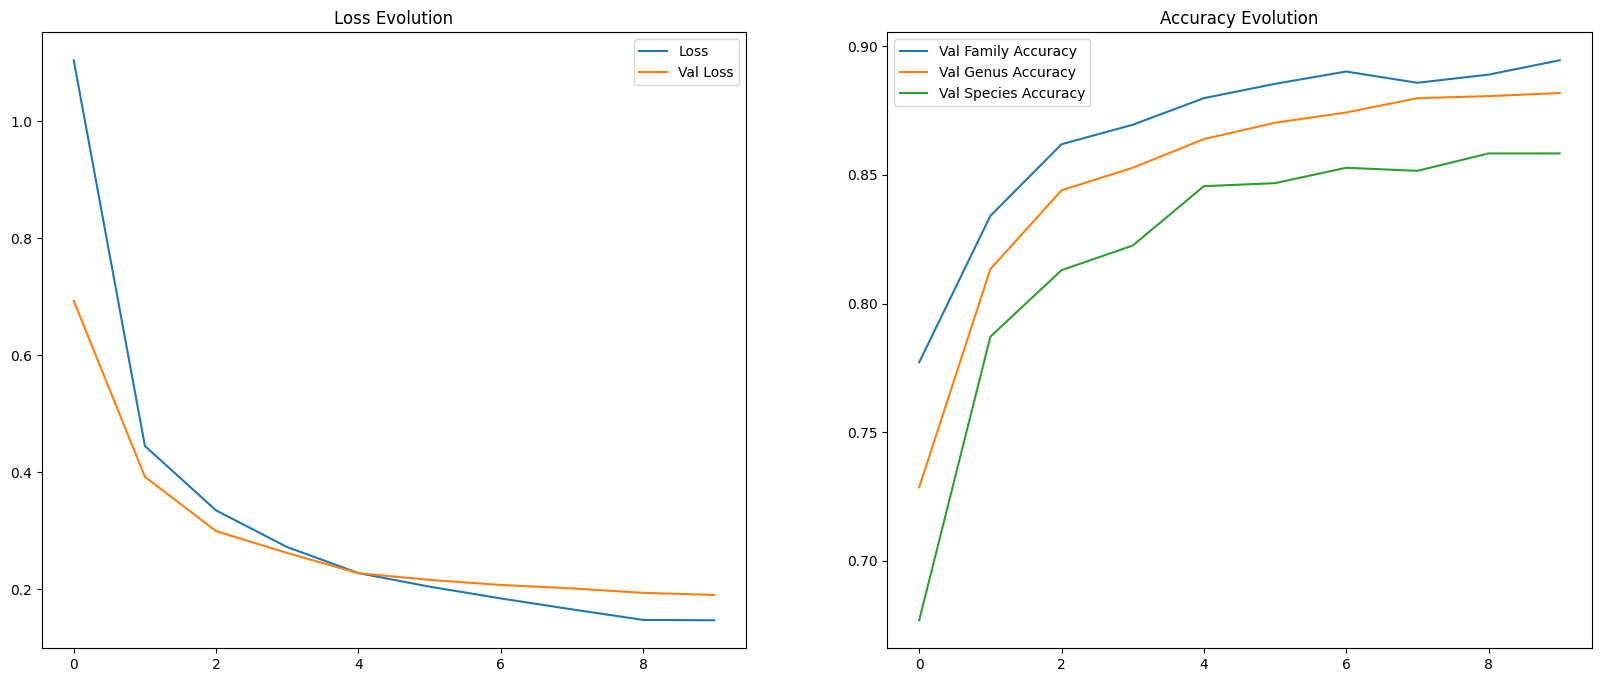

In [10]:
# Using history to plot the training and validation loss and accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['val_family_accuracy'], label='Val Family Accuracy')
plt.plot(history.history['val_genus_accuracy'], label='Val Genus Accuracy')
plt.plot(history.history['val_species_accuracy'], label='Val Species Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.show()



In [7]:
from keras import layers

# Fine-tuning
base_model = model_shared_eff.layers[1]

for layer in base_model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
    
print(f"Unfreezing the last {20} layers")

model_shared_eff.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
    loss = 'categorical_focal_crossentropy',
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
)




total_epochs =  15

history_fine = model_shared_eff.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history.epoch),
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=0  # Suppress TensorFlow default output
)

Unfreezing the last 20 layers


Epoch 11/15: 100%|██████████| 92/92 [01:24<00:00,  1.09batch/s, loss=0.0717, family_acc=0.9631, genus_acc=0.9633, species_acc=0.9541]


2025-01-07 15:52:35.021 | INFO     | __main__:on_epoch_end:53 - Epoch 11 completed - Loss: 0.0717, Val Family Accuracy: 0.9156, Val Genus Accuracy: 0.9049, Val Species Accuracy: 0.8906


Epoch 12/15: 100%|██████████| 92/92 [01:06<00:00,  1.39batch/s, loss=0.0691, family_acc=0.9622, genus_acc=0.9640, species_acc=0.9565]


2025-01-07 15:53:41.307 | INFO     | __main__:on_epoch_end:53 - Epoch 12 completed - Loss: 0.0691, Val Family Accuracy: 0.9176, Val Genus Accuracy: 0.9049, Val Species Accuracy: 0.8918


Epoch 13/15: 100%|██████████| 92/92 [01:07<00:00,  1.36batch/s, loss=0.0659, family_acc=0.9657, genus_acc=0.9666, species_acc=0.9564]


2025-01-07 15:54:48.727 | INFO     | __main__:on_epoch_end:53 - Epoch 13 completed - Loss: 0.0659, Val Family Accuracy: 0.9184, Val Genus Accuracy: 0.9041, Val Species Accuracy: 0.8930


Epoch 14/15: 100%|██████████| 92/92 [01:06<00:00,  1.38batch/s, loss=0.0636, family_acc=0.9633, genus_acc=0.9686, species_acc=0.9590]


2025-01-07 15:55:55.509 | INFO     | __main__:on_epoch_end:53 - Epoch 14 completed - Loss: 0.0636, Val Family Accuracy: 0.9184, Val Genus Accuracy: 0.9065, Val Species Accuracy: 0.8945


Epoch 15/15: 100%|██████████| 92/92 [01:07<00:00,  1.36batch/s, loss=0.0607, family_acc=0.9665, genus_acc=0.9689, species_acc=0.9593]

2025-01-07 15:57:03.031 | INFO     | __main__:on_epoch_end:53 - Epoch 15 completed - Loss: 0.0607, Val Family Accuracy: 0.9196, Val Genus Accuracy: 0.9065, Val Species Accuracy: 0.8953


In [8]:
def plot_training_history(history, history_fine, fine_tune_at):
    """
    Plot the training history of accuracy and loss for each output.
    
    Args:
    - history (History): History object from the initial training.
    - history_fine (History): History object from the fine-tuning phase.
    - fine_tune_at (int): Epoch at which fine-tuning began.
    """
    # Combine initial training history and fine-tuning history
    accuracy_keys = ['family_accuracy', 'genus_accuracy', 'species_accuracy']
    val_accuracy_keys = ['val_family_accuracy', 'val_genus_accuracy', 'val_species_accuracy']
    loss_keys = ['family_loss', 'genus_loss', 'species_loss']
    val_loss_keys = ['val_family_loss', 'val_genus_loss', 'val_species_loss']

    # Combine the data from the initial training and fine-tuning phases
    combined_history = {}
    for key in accuracy_keys + val_accuracy_keys + loss_keys + val_loss_keys:
        combined_history[key] = history.history.get(key, []) + history_fine.history.get(key, [])

    total_epochs = len(combined_history[accuracy_keys[0]])  # Total number of epochs including fine-tuning
    
    # Create subplots for accuracy and loss
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot accuracy for each output
    for idx, key in enumerate(accuracy_keys):
        axs[0, idx].plot(combined_history[key], label='Training Accuracy')
        axs[0, idx].plot(combined_history[val_accuracy_keys[idx]], label='Validation Accuracy')
        axs[0, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[0, idx].set_title(f'{key.replace("_accuracy", "").capitalize()} Accuracy')
        axs[0, idx].set_xlabel('Epochs')
        axs[0, idx].set_ylabel('Accuracy')
        axs[0, idx].legend()
        axs[0, idx].grid(True)
    
    # Plot loss for each output
    for idx, key in enumerate(loss_keys):
        axs[1, idx].plot(combined_history[key], label='Training Loss')
        axs[1, idx].plot(combined_history[val_loss_keys[idx]], label='Validation Loss')
        axs[1, idx].axvline(x=fine_tune_at, color='r', linestyle='--', label='Fine-Tuning Start')
        axs[1, idx].set_title(f'{key.replace("_loss", "").capitalize()} Loss')
        axs[1, idx].set_xlabel('Epochs')
        axs[1, idx].set_ylabel('Loss')
        axs[1, idx].legend()
        axs[1, idx].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [11]:
plot_training_history(history, history_fine, fine_tune_at=0)

NameError: name 'history_fine' is not defined

In [ ]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

inputs = Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = resnet_preprocess(x)
x = base_model(x, training=False)

def model_hierarchical_v01(inputs, x, features=None):
    
    if not features:
        features = GlobalAveragePooling2D()(x)
        
    shared_layer = Dense(1024,name='shared_layer')(features)
    shared_layer = BatchNormalization()(shared_layer)
    shared_layer = Activation('relu')(shared_layer)
        
    # Family Output
    family_hidden = Dense(64,name='family_hidden')(shared_layer)
    family_hidden = BatchNormalization()(family_hidden)
    family_hidden = Activation('relu')(family_hidden)
    family_output = Dense(len(names['family']), activation='softmax',name='family')(family_hidden)

    # Genus Output
    genus_hidden = Concatenate()([shared_layer, family_hidden])
    genus_hidden = BatchNormalization()(genus_hidden)
    genus_output = Dense(len(names['genus']), activation='softmax',name='genus')(genus_hidden)

    # Species Output
    species_hidden = Concatenate()([shared_layer, genus_hidden])
    species_hidden = BatchNormalization()(species_hidden)
    species_output = Dense(len(names['species']), activation='softmax',name='species')(species_hidden)

    model = tf.keras.Model(
        inputs, 
        [family_output, genus_output, species_output], 
        name='cryptovision_resnet50v2'
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalFocalCrossentropy(),
        metrics = {
            'family': ["accuracy", "AUC", "Precision", "Recall"],
            'genus': ["accuracy", "AUC", "Precision", "Recall"],
            'species': ["accuracy", "AUC", "Precision", "Recall"],
        },
    )
    
    return model

model_hier_v01 = model_hierarchical_v01(inputs, x)

model_hier_v01.summary()